In [31]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pathlib
import functools
import itertools as it

import matplotlib as mpl
mpl.style.use('bmh')
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely import geometry
import rasterio
from rasterio.transform import (
    Affine,
    from_bounds,
)
from rasterio.crs import CRS
from rasterio.features import rasterize

In [269]:
def build_grid(minx: float, maxx: float, miny: float, maxy: float, resolution: float, offset: float) -> gpd.GeoDataFrame:
    """
    Args:
        {min,max}{x,y}: Bounding box for the stuff that the grid should cover.
        resolution: width and height of each cell.
        offset: Amount which lower-left corner of the grid should be shifted
            left and down in order to provide padding to the stuff to cover
            up and to make possible to align different-resolution grids.
    
    """
    grid_x = np.arange(minx, maxx + resolution, resolution) - offset
    grid_y = np.arange(miny, maxy + resolution, resolution) - offset
    cells = [
        geometry.box(
            cell_minx,
            cell_miny,
            cell_minx + resolution,
            cell_miny + resolution,
        )
        for cell_minx in grid_x
        for cell_miny in grid_y
    ]

    # Build geometries into geopandas dataframe
    return gpd.GeoDataFrame(cells, columns=['geometry'])

def build_points(minx: float, maxx: float, miny: float, maxy: float, resolution: float, spread: bool = False) -> gpd.GeoDataFrame:
    if spread:
        # Interval [0; 1]
        x, y = np.random.random(size=(2, 10000))
        # Scale intervals
        x *= maxx - minx
        y *= maxy - miny
        # Align with nearest lower off-resolution
        x -= x % (resolution / 3)
        y -= y % (resolution / 3)
    else:
        x_choices = np.arange(minx, maxx, resolution)
        y_choices = np.arange(miny, maxy, resolution)
        x = np.random.choice(x_choices, 30, replace=False)
        y = np.random.choice(y_choices, 30, replace=False)
        
    return gpd.GeoDataFrame(geometry=gpd.points_from_xy(x, y))


In [270]:
# Set boundary
minx, maxx, miny, maxy = 0, 5, 0, 5

# Build grids
offset = .1
resolution_hi = .2
resolution_lo = .4
hi = build_grid(minx, maxx, miny, maxy, resolution=resolution_hi, offset=offset)
lo = build_grid(minx, maxx, miny, maxy, resolution=resolution_lo, offset=offset)

# Create points
points = build_points(minx, maxx, miny, maxy, resolution=resolution_hi / 3, spread=True)

/home/e088195/bin/miniconda3/envs/diveg/lib/python3.9/site-packages/geopandas/base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


<AxesSubplot:>

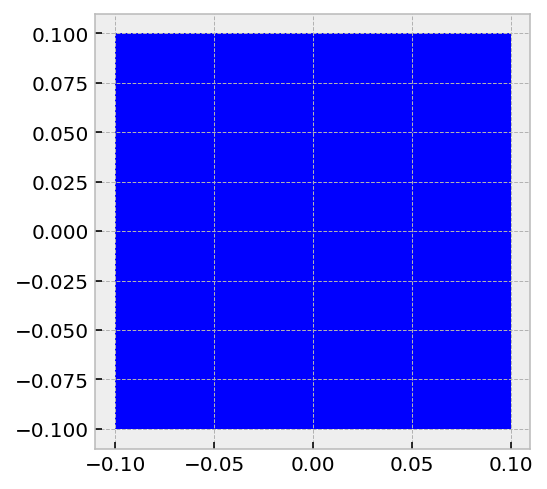

In [271]:
hi_within = hi[hi.within(lo)]
hi_within.geometry.plot()

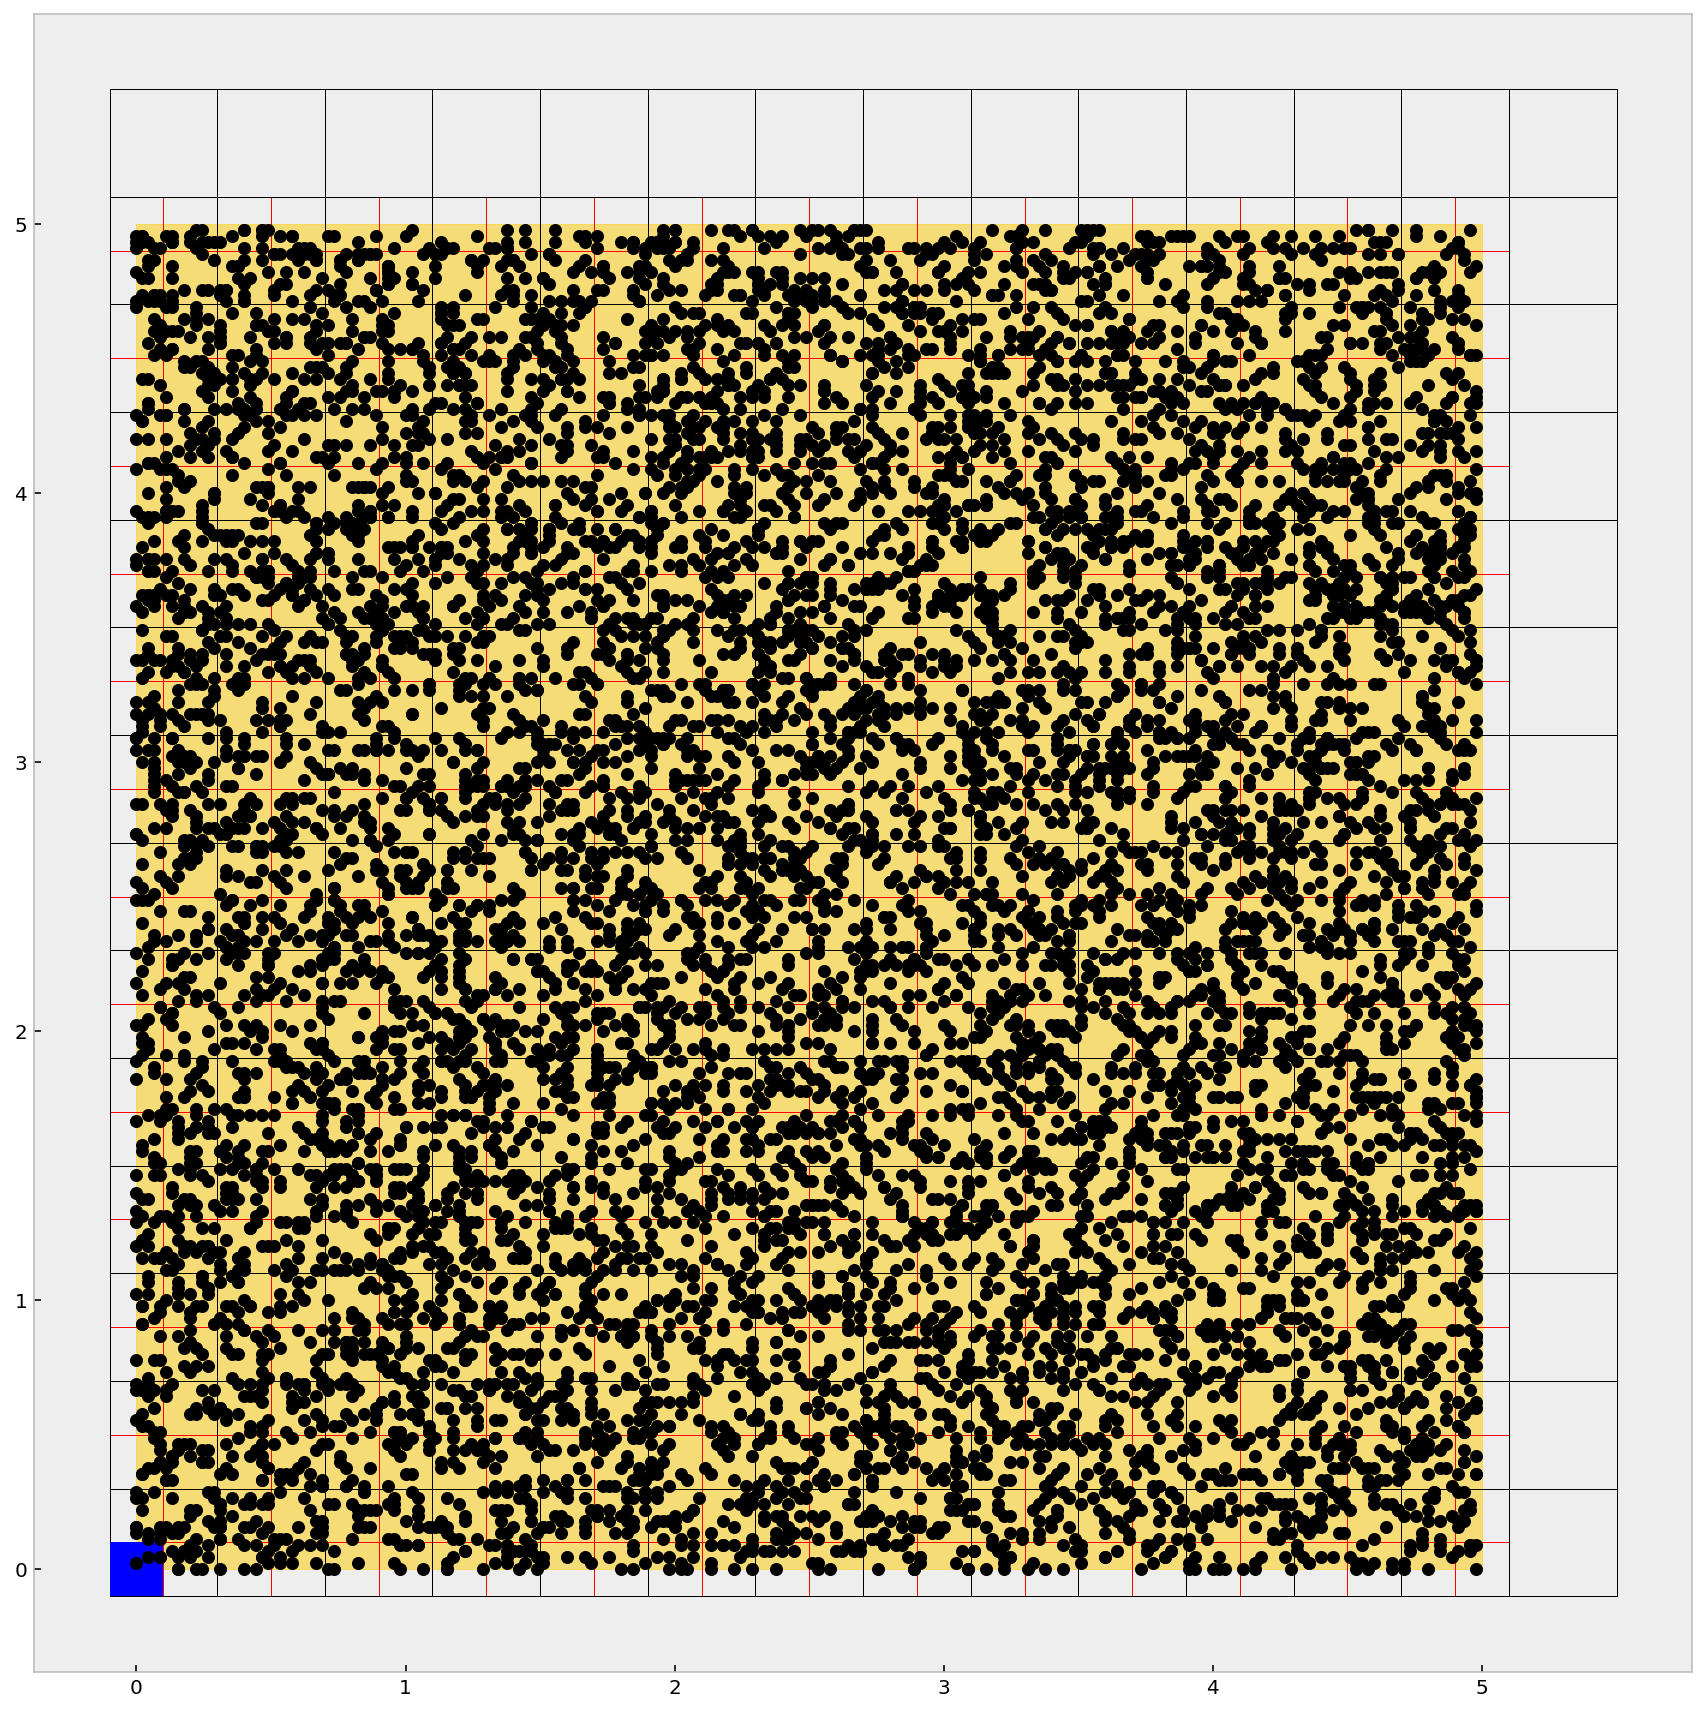

In [272]:
"""
The rectangle-generating code is included with the plot-creation code,
since re-plotting (re-running the plot code) alone will raise an error
about adding an artist in more than one figure.

This way, a new rectangle (and thus a new artist) is created before plotting.

"""
# Add a rectangle showing the boundary
grid_bounds = mpl.patches.Rectangle(
    xy=np.array((minx, miny)),
    width=(maxx - minx),
    height=(maxy - miny),
    color='#ffcc00',
    zorder=-1,
    alpha=.5
)

gkw = dict(facecolor='none')

fig, ax = plt.subplots(figsize=(12, 12))
hi.plot(ax=ax, edgecolor='#ff0000', **gkw)
lo.plot(ax=ax, edgecolor='#000000', **gkw)
ax.add_patch(grid_bounds)
hi_within.geometry.plot(ax=ax)
points.plot(ax=ax, color='#000000')
ax.grid(False)
fig.tight_layout()
plt.savefig('grid-cell-size-smearing.pdf')
plt.savefig('grid-cell-size-smearing.png')

## Observations

* Any grid produced in this way covers some area around the edge of the data, which means that values in each cell is smeared over too large an area in these places.
* Lower-resolution grids cause this smearing to occur over a larger area than a higher-resolution grid.
* 

In [273]:
hi_covers_indices = hi.sindex.query_bulk(lo.geometry, predicate='covers')
# hi_covers_indices

# hi_covers = hi.iloc[hi_covers_indices]
# hi_covers
# hi_covers.plot()

<AxesSubplot:>

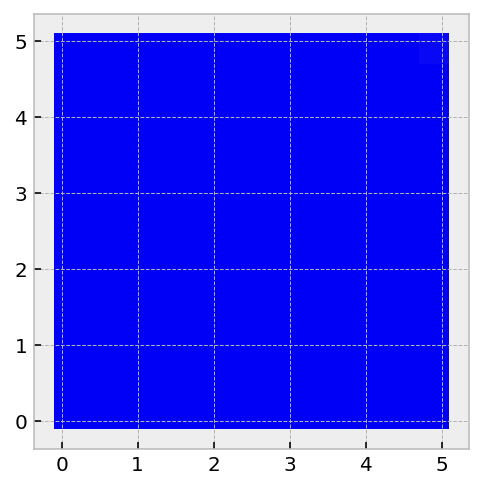

In [274]:
"""
FROM: https://github.com/geopandas/geopandas/blob/master/geopandas/sindex.py

s.sindex.valid_query_predicates  # doctest: +SKIP
        {'contains', 'crosses', 'intersects', 'within', 'touches', \
'overlaps', None, 'covers', 'contains_properly'}

"""

input_geometry_integer_indexes, tree_geometry_integer_indexes = points.sindex.query_bulk(lo.geometry, predicate='covers')
input_geometry_results = lo.iloc[input_geometry_integer_indexes]
input_geometry_results.plot(alpha=.1)

In [275]:
predicates = {'contains', 'crosses', 'intersects', 'within', 'touches', 'overlaps', None, 'covers', 'contains_properly'}

In [276]:
results_hi_predicate_lo = {
    predicate: hi.iloc[np.unique(points.sindex.query_bulk(hi.geometry, predicate=predicate)[0])]
    for predicate in predicates
}

/home/e088195/bin/miniconda3/envs/diveg/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/e088195/bin/miniconda3/envs/diveg/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/e088195/bin/miniconda3/envs/diveg/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


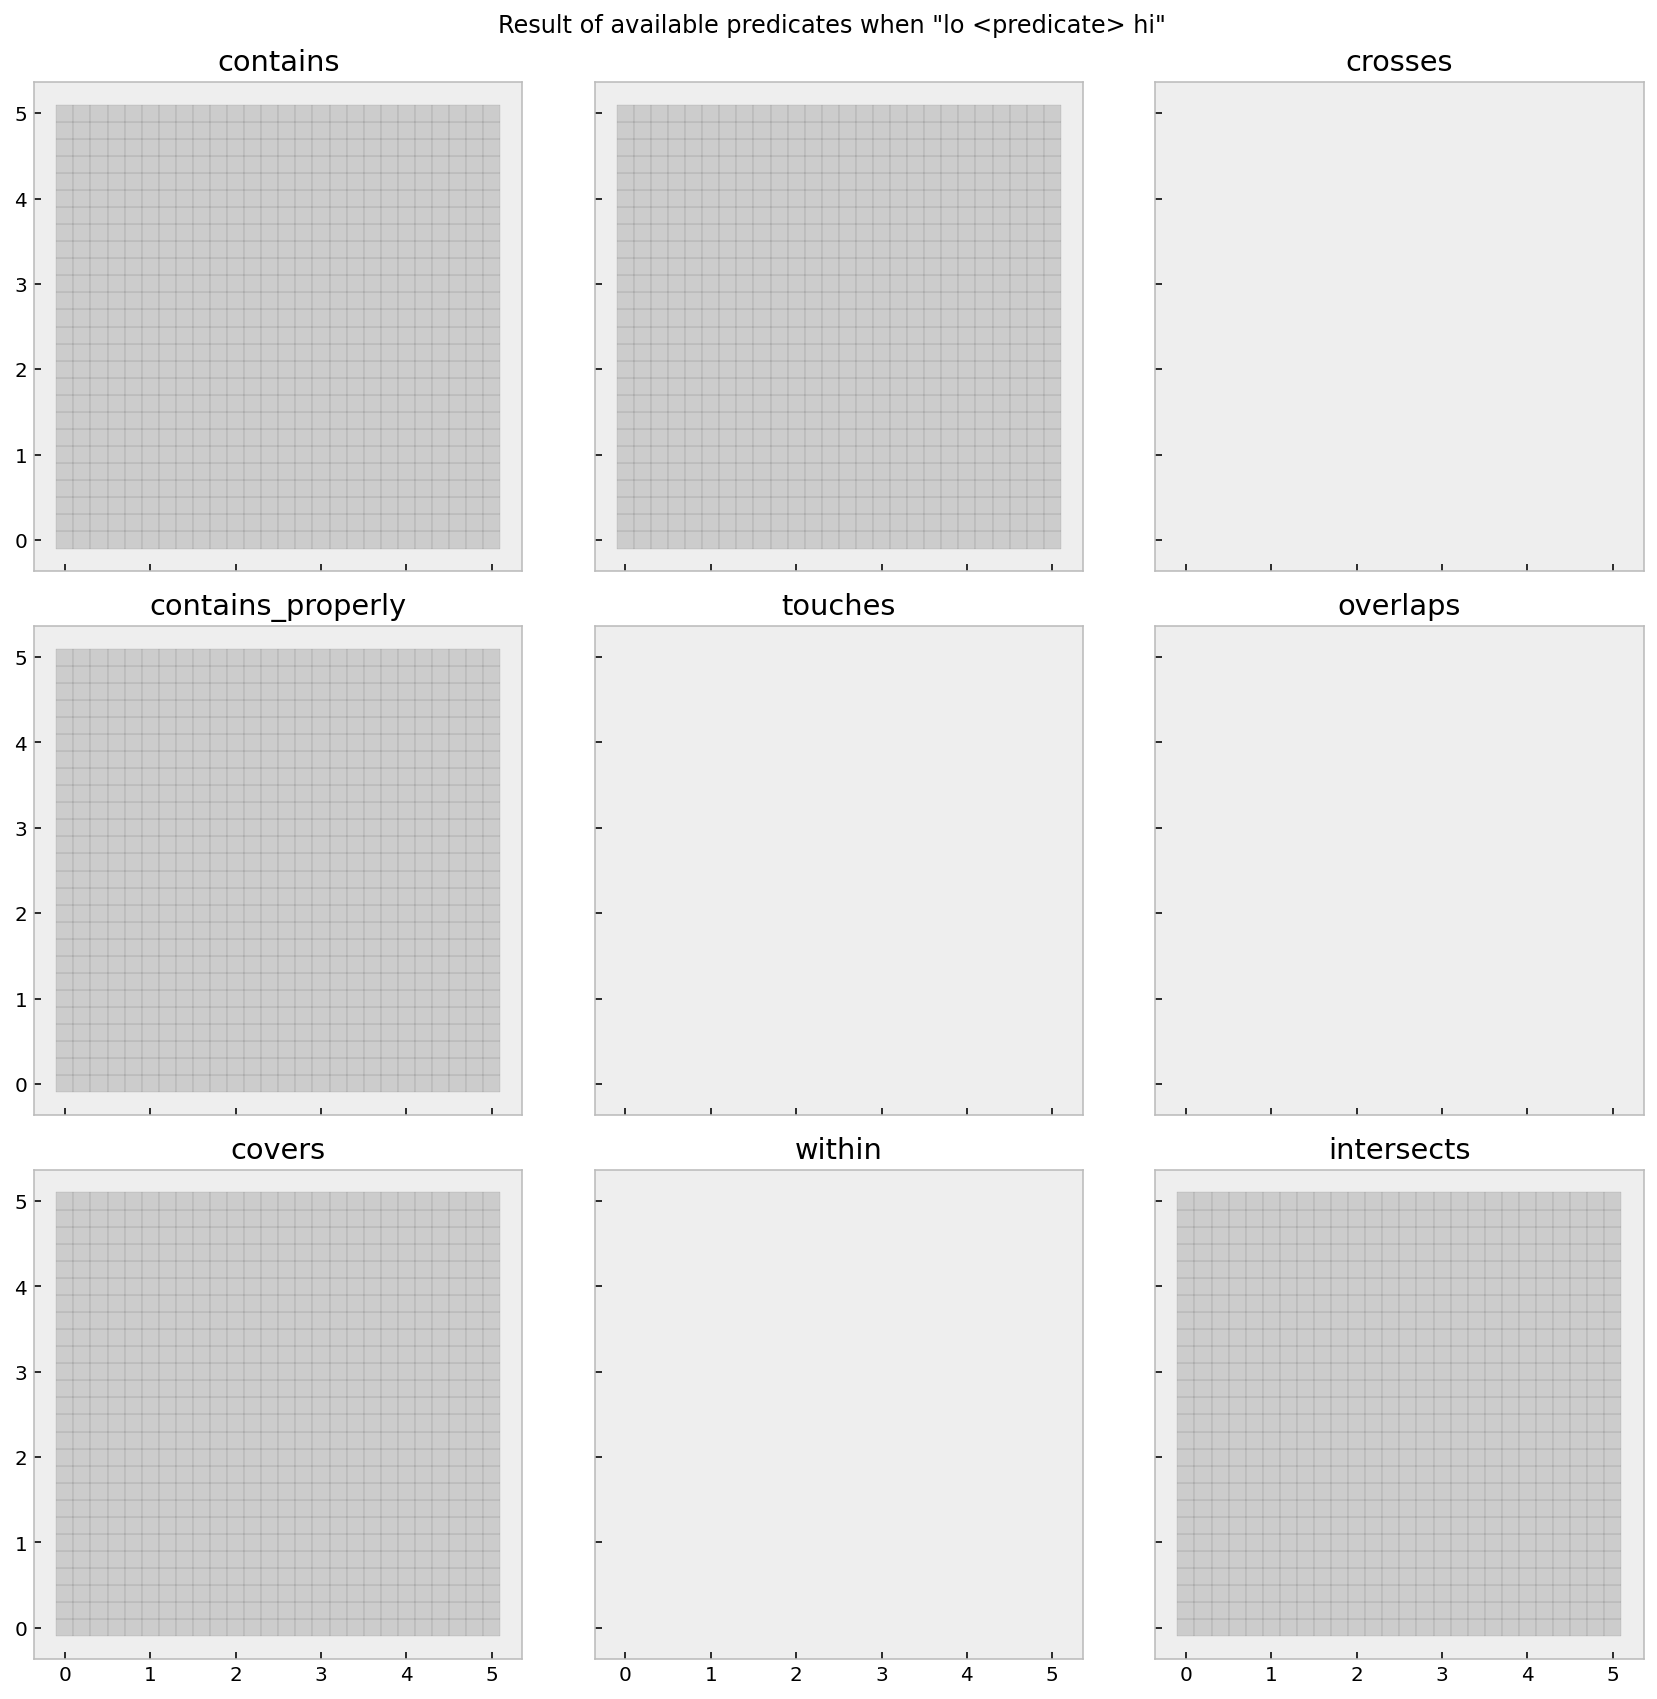

In [277]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 12), sharex=True, sharey=True)
for (ax, (predicate, result)) in zip(axes.flat, results_hi_predicate_lo.items()):
    result.plot(ax=ax, fc='#999999', ec='#000000', lw=.1, alpha=.4)
    ax.set_title(predicate)
    ax.grid(False)
fig.suptitle('Result of available predicates when "lo <predicate> hi"')
fig.tight_layout()
plt.savefig('lo-predicates-hi.pdf')
plt.savefig('lo-predicates-hi.png')

In [278]:
results_lo_predicate_hi = {
    predicate: lo.iloc[np.unique(points.sindex.query_bulk(lo.geometry, predicate=predicate)[0])]
    for predicate in predicates
}

/home/e088195/bin/miniconda3/envs/diveg/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/e088195/bin/miniconda3/envs/diveg/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/e088195/bin/miniconda3/envs/diveg/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


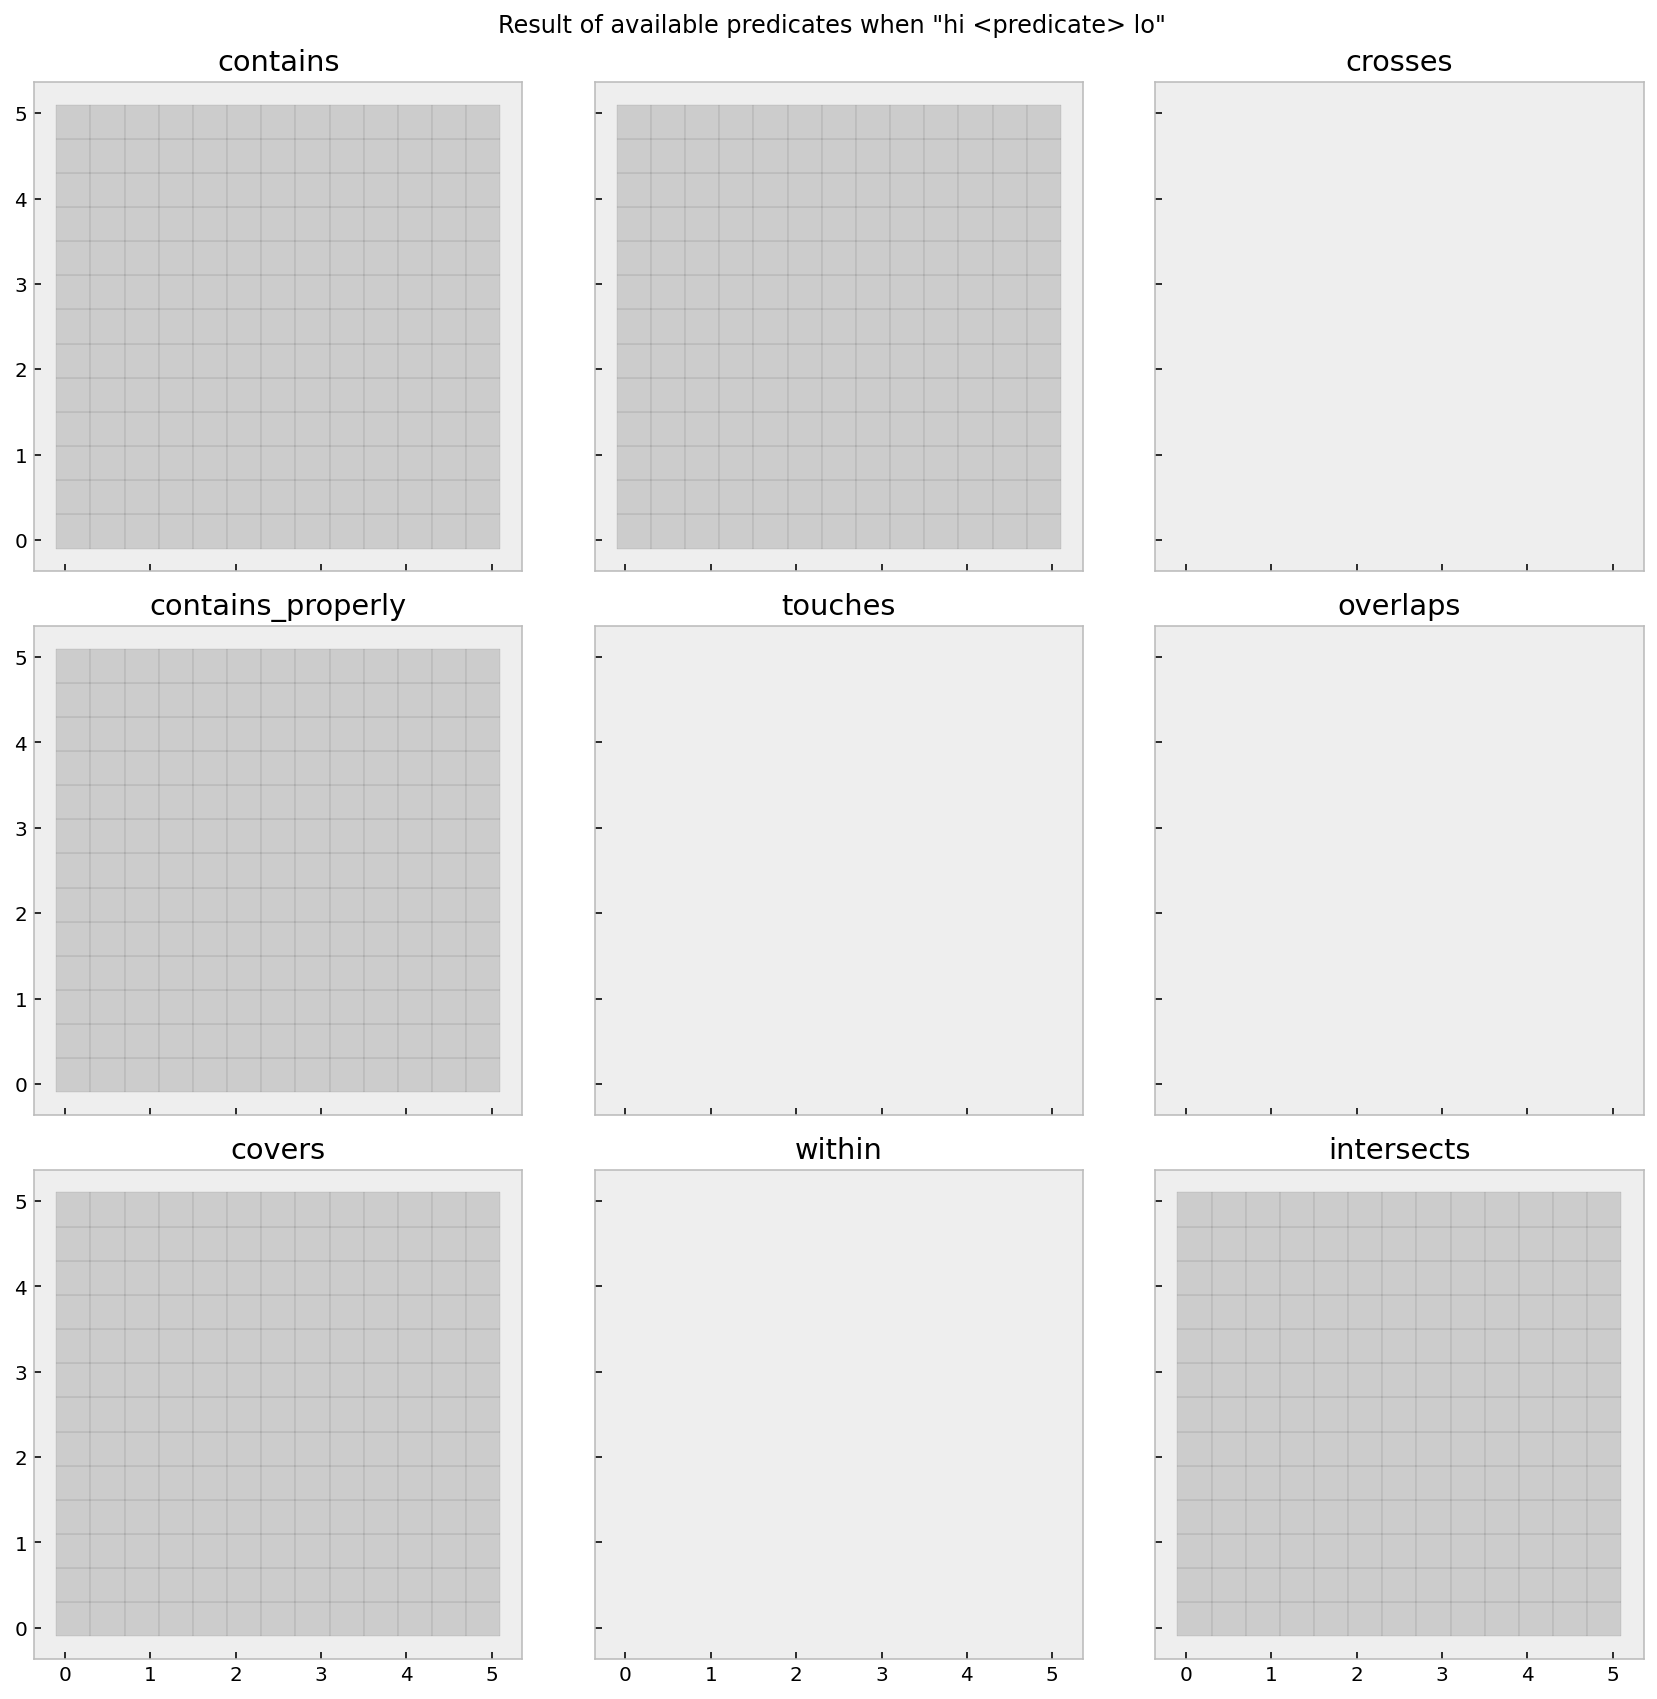

In [279]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 12), sharex=True, sharey=True)
for (ax, (predicate, result)) in zip(axes.flat, results_lo_predicate_hi.items()):
    result.plot(ax=ax, fc='#999999', ec='#000000', lw=.1, alpha=.4)
    ax.set_title(predicate)
    ax.grid(False)
fig.suptitle('Result of available predicates when "hi <predicate> lo"')
fig.tight_layout()
plt.savefig('lo-predicates-hi.pdf')
plt.savefig('lo-predicates-hi.png')

## In the following, the method `sindex.query` rather than `sindex.query_bulk` which returns different output

In [248]:
# indexed, input_geometry = lo, hi
indexed, input_geometry = hi, lo
# indexed, input_geometry = points, lo
outputs = []
for cell in input_geometry.geometry:  # [:20]:
    indices = indexed.sindex.query(cell, predicate='touches')
    outputs.append(indexed.iloc[indices])


/home/e088195/bin/miniconda3/envs/diveg/lib/python3.9/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


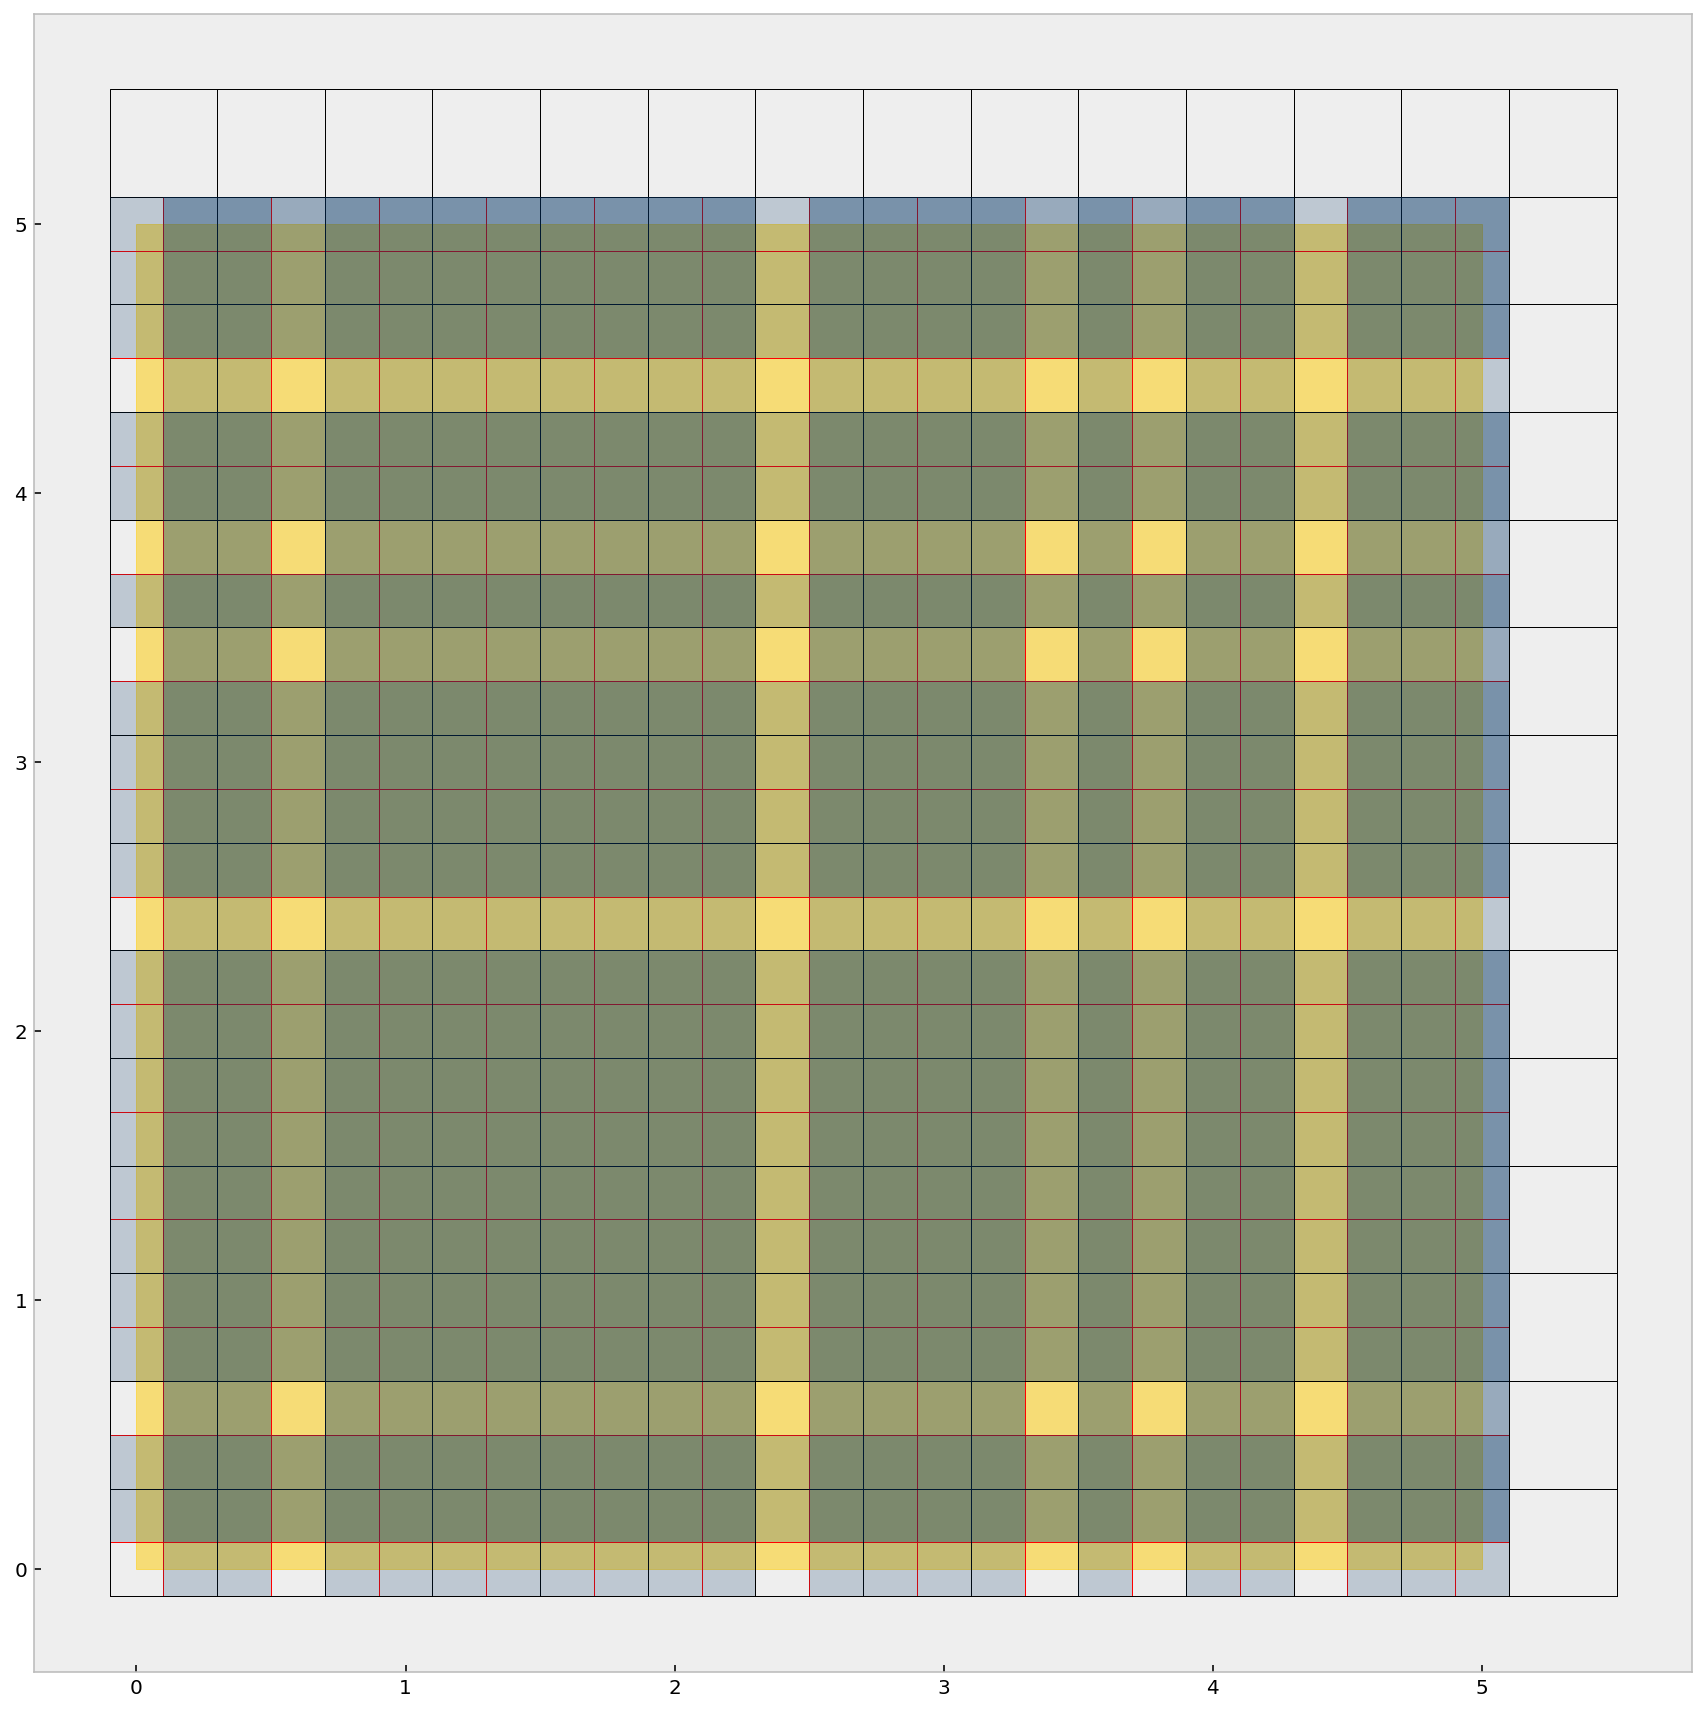

In [249]:
# Add a rectangle showing the boundary
data_bounds = mpl.patches.Rectangle(
    xy=(minx, miny),
    width=(maxx - minx),
    height=(maxy - miny),
    color='#ffcc00',
    zorder=-1,
    alpha=.5
)

gkw = dict(facecolor='none')
colors = (
    '#e8af06',
    '#41acd3',
    '#cc08dd',
    '#37bfaa',
    '#db6d41',
    '#bf2445',
    '#aece46',
    '#52ce6f',
    '#450de0',
    '#c4ce31',
)
colors = ('#003366',)

fig, ax = plt.subplots(figsize=(12, 12))
hi.plot(ax=ax, edgecolor='#ff0000', **gkw)
lo.plot(ax=ax, edgecolor='#000000', **gkw)
ax.add_patch(data_bounds)
for (coverage, color) in zip(outputs, it.cycle(colors)):
    coverage.geometry.plot(ax=ax, fc=color, alpha=.2)

ax.grid(False)
fig.tight_layout()
plt.savefig('lo-covering-hi.pdf')
plt.savefig('lo-covering-hi.png')
